# `CleanSamples` model

# DeepLift

In [1]:
import deeplift
import deeplift.conversion.kerasapi_conversion as kc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import pkg_resources

/mnt/BioAdHoc/Groups/RaoLab/Edahi/00.Scripts/01.Downloaded/anaconda3/envs/deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/BioAdHoc/Groups/RaoLab/Edahi/00.Scripts/01.Downloaded/anaconda3/envs/deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/BioAdHoc/Groups/RaoLab/Edahi/00.Scripts/01.Downloaded/anaconda3/envs/deeplift/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it wi

In [2]:
# We have dense layers, using Genomics Default
nonlinear_mxts_mode = deeplift.layers.NonlinearMxtsMode.DeepLIFT_GenomicsDefault

# We are interested in the importance of the input, which means interested in layer 0
find_scores_layer_idx = 0

# We have Sigmoid output function, which means we want to compute w.r.t. logits
target_layer_idx = -2

# load the keras model
keras_model_json = "./clean_samples_model_mac.json"
keras_model_weights = "./clean_samples_weights_mac.h5"

# Generate model with given method
deeplift_model = kc.convert_model_from_saved_files(
    h5_file=keras_model_weights,
    json_file=keras_model_json,
    nonlinear_mxts_mode=nonlinear_mxts_mode,
)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 0 the preceding linear layer is preact_0 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 2 the preceding linear layer is preact_2 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 4 the preceding linear layer is preact_4 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
For layer 5 the preceding linear layer is preact_5 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel


### Loading Datasets

In [3]:
# # Loading the dataset
# X = np.load(
#     "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_Train_X.npz"
# )["arr_0"].T
# Y = np.load(
#     "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_Train_Y.npz"
# )["arr_0"].T
# print(
#     f"""
# Training examples: {X.shape[0]}
# X_train shape: {X.shape}
# Y_train shape: {Y.shape}
# """
# )

X_dev = np.load(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_Dev_X.npz"
)["arr_0"].T
Y_dev = np.load(
    "/mnt/BioAdHoc/Groups/RaoLab/Edahi/Projects/09.TimeCourse5hmC/ForFerhatGit/FCDNN/data/C2B_Merged/CleanSamples_Dev_Y.npz"
)["arr_0"].T

print(
    f"""
Development examples: {X_dev.shape[0]}
X_dev shape: {X_dev.shape}
Y_dev shape: {Y_dev.shape}
"""
)


Training examples: 933009
Development examples: 64484

X_train shape: (933009, 230)
Y_train shape: (933009, 1)
X_dev shape: (64484, 230)
Y_dev shape: (64484, 1)



In [4]:
# Generate contribution functions
deeplift_contribs_func = deeplift_model.get_target_contribs_func(
    find_scores_layer_idx=find_scores_layer_idx, target_layer_idx=target_layer_idx
)

MAKING A SESSION


## Load probabilites of tested data

In [18]:
Side2Prob = pd.read_csv(
    "./Probabilities_Keras_CleanSamples_e60_L200_100_50_1.csv"
)
Side2Prob

TrueNegative = (Side2Prob["Observed"] == 0) & (Side2Prob["Probability"] <= 0.21)
TruePositive = (Side2Prob["Observed"] == 1) & (Side2Prob["Probability"] >= 0.79)

TN = X_dev[TrueNegative, :]
TP = X_dev[TruePositive, :]

## Generate reference values

A neutral reference is designed to neither elicit a positive nor a negative response from the network. \
Essentially, it introduces a state of ambiguity:
> **activating the network without biasing it towards a prediction of either a positive (1) or a negative (0) outcome.**

This neutrality ensures that the network remains in a balanced state of activation, \
refraining from leaning towards any definitive classification.

In [48]:
# 3.8600 was obtained in the `fcdnn_keras_cleansamples_generate_model.ipynb`
NeuRef = np.full((1, 230), 3.860, dtype=np.float32)

### True Negatives

In [49]:
print("Calculating TN Scores from Random Referece")
TNscores_RandRef = np.array(
    deeplift_contribs_func(
        task_idx=0,
        input_data_list=[TN],
        input_references_list=NeuRef,
        batch_size=10,
        progress_update=1000,
    )
)

Calculating TN Scores from Random Referece
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
Done 11000
Done 12000
Done 13000
Done 14000


### True Positives

In [50]:
TPscores_RandRef = np.array(
    deeplift_contribs_func(
        task_idx=0,
        input_data_list=[TP],
        input_references_list=NeuRef,
        batch_size=10,
        progress_update=10,
    )
)

Done 0
Done 10
Done 20
Done 30
Done 40
Done 50
Done 60
Done 70
Done 80
Done 90
Done 100
Done 110
Done 120
Done 130
Done 140
Done 150
Done 160
Done 170
Done 180
Done 190
Done 200
Done 210
Done 220
Done 230
Done 240
Done 250
Done 260
Done 270
Done 280
Done 290
Done 300
Done 310
Done 320
Done 330
Done 340
Done 350
Done 360
Done 370
Done 380
Done 390
Done 400
Done 410
Done 420
Done 430
Done 440
Done 450
Done 460
Done 470
Done 480
Done 490
Done 500
Done 510
Done 520
Done 530
Done 540
Done 550
Done 560
Done 570
Done 580
Done 590
Done 600
Done 610
Done 620
Done 630
Done 640
Done 650
Done 660
Done 670
Done 680
Done 690
Done 700
Done 710
Done 720
Done 730
Done 740
Done 750
Done 760
Done 770
Done 780
Done 790
Done 800
Done 810
Done 820
Done 830
Done 840
Done 850
Done 860
Done 870
Done 880
Done 890
Done 900
Done 910
Done 920
Done 930
Done 940
Done 950
Done 960
Done 970
Done 980
Done 990
Done 1000
Done 1010
Done 1020
Done 1030
Done 1040
Done 1050
Done 1060
Done 1070
Done 1080
Done 1090
Done 1100
D

### Save results for plotting

In [51]:
np.savetxt(
    "TNscores_NeutralRef_CleanSamples_Net200-100-50-1.csv",
    TNscores_RandRef,
    delimiter=",",
)
np.savetxt(
    "TPscores_NeutralRef_CleanSamples_Net200-100-50-1.csv",
    TPscores_RandRef,
    delimiter=",",
)

In [52]:
# Load the data for the graph
PR_TP_B_Net01 = pd.read_csv(
    "./TPscores_NeutralRef_CleanSamples_Net200-100-50-1.csv", header=None
).to_numpy()
NR_TN_B_Net01 = pd.read_csv(
    "./TNscores_NeutralRef_CleanSamples_Net200-100-50-1.csv", header=None
).to_numpy()

In [53]:
# Assuming 'Bin' is a predefined variable you have - you'd need to adjust this part
Bin = np.concatenate(
    [
        [f"Prom_Neg_{i:03d}" for i in range(50, 0, -1)],
        [f"Prom_Pos_{i:03d}" for i in range(1, 51)],
        [f"TSS_{i:03d}" for i in range(15, 0, -1)],
        [f"Gbody_{i:03d}" for i in range(1, 101)],
        [f"TTS_{i:03d}" for i in range(1, 16)],
    ]
)
assert Bin.shape[0] == 230

In [54]:
Bin_repeated_TP = np.tile(Bin, PR_TP_B_Net01.shape[0])
Bin_repeated_TN = np.tile(Bin, NR_TN_B_Net01.shape[0])
assert Bin_repeated_TP.shape[0] == PR_TP_B_Net01.flatten().shape[0]

In [55]:
# Create DataFrames
pTP = pd.DataFrame(
    {"Score": PR_TP_B_Net01.flatten(), "Bin": Bin_repeated_TP, "Label": "Neutral_TP"}
)

nTN = pd.DataFrame(
    {"Score": NR_TN_B_Net01.flatten(), "Bin": Bin_repeated_TN, "Label": "Neutral_TN"}
)

# Concatenate DataFrames
All = pd.concat([pTP, nTN])
All.head()

,Score,Bin,Label
0,0.012287,Prom_Neg_050,Neutral_TP
1,-0.099095,Prom_Neg_049,Neutral_TP
2,-0.342774,Prom_Neg_048,Neutral_TP
3,-0.103654,Prom_Neg_047,Neutral_TP
4,-0.073323,Prom_Neg_046,Neutral_TP


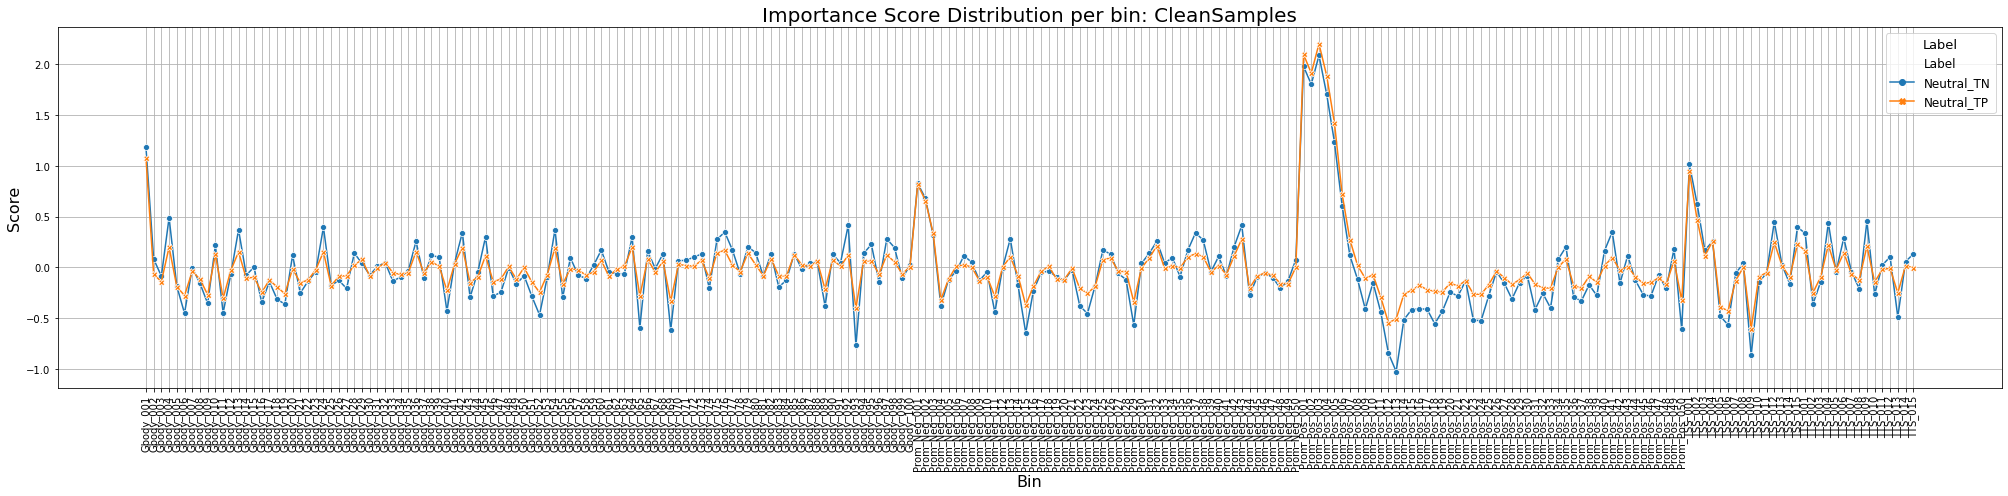

In [56]:
# Aggregate the data (mean, std) - simulating 'data_summary' from R
agg_df = All.groupby(["Bin", "Label"]).agg(["mean", "std"]).reset_index()
agg_df.columns = ["Bin", "Label", "Mean_Score", "SD"]

# Plotting
plt.figure(figsize=(28, 7))
sns.lineplot(
    data=agg_df,
    x="Bin",
    y="Mean_Score",
    hue="Label",
    style="Label",
    markers=True,
    dashes=False,
    err_style="bars",
    ci="sd",
)
plt.title("Importance Score Distribution per bin: CleanSamples", fontsize=20)
plt.xlabel("Bin", fontsize=16)
plt.ylabel("Score", fontsize=16)
plt.xticks(rotation=90)
# plt.ylim(-0.5, 0.5)
plt.grid(True)
plt.legend(title="Label", title_fontsize="13", fontsize="12")
plt.tight_layout()

plt.savefig("./CleanSamples_Neutral_Python.pdf")
plt.show()

In [57]:
# def get_imported_packages_with_versions():
#     imported_packages = set([module.split('.')[0] for module in sys.modules.keys() if module.split('.')[0]])
#     imported_packages_with_versions = {}

#     for pkg in imported_packages:
#         try:
#             version = pkg_resources.get_distribution(pkg).version
#             imported_packages_with_versions[pkg] = version
#         except (pkg_resources.DistributionNotFound, pkg_resources.ExtractionError, pkg_resources.VersionConflict, Exception):
#             # Skip packages that cause issues
#             pass

#     return imported_packages_with_versions

# imported_packages_with_versions = get_imported_packages_with_versions()

# # Print the package names and their versions
# for pkg, version in imported_packages_with_versions.items():
#     print(f"{pkg}: {version}")
